In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from fastai.vision.all import *
from PIL import ImageFile
import os
import matplotlib.pyplot as plt

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### histopathologic-cancer-detection

We have images that show images that may have cancer on them or not. We have labels saying 0 (no) or 1 (yes). 

In this project we will use FastAI and transfer learning to leverage ResNet and train it on these images. 



In [47]:
data = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
#data["label"] = data["label"].astype(str)
data["id"] = "/kaggle/input/histopathologic-cancer-detection/train/" + data["id"] + ".tif"
data = data.head(500)

We are modifying the "id" column to get the full file paths. 

In [48]:
data.head()

,id,label
0,/kaggle/input/histopathologic-cancer-detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,/kaggle/input/histopathologic-cancer-detection/train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,/kaggle/input/histopathologic-cancer-detection/train/755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,/kaggle/input/histopathologic-cancer-detection/train/bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,/kaggle/input/histopathologic-cancer-detection/train/068aba587a4950175d04c680d38943fd488d6a9d.tif,0


This is how we want it to look.

Now let's take a look at some sample images. 


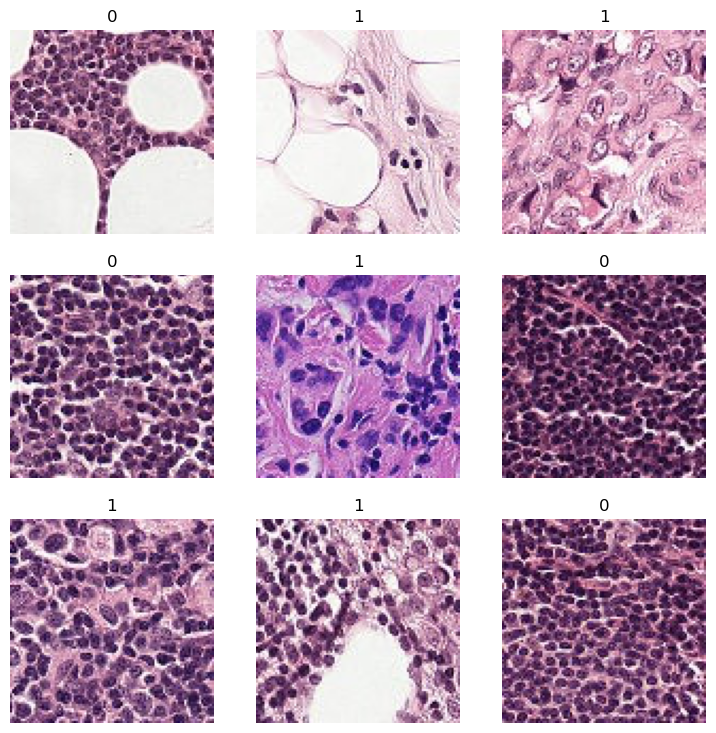

In [49]:
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('id'),
    get_y=ColReader('label'),
    splitter=RandomSplitter()
)
dls = data_block.dataloaders(data, valid_pct = 0.2, item_tfms=Resize(50, ResizeMethod.Squish))
dls.show_batch()

# Train
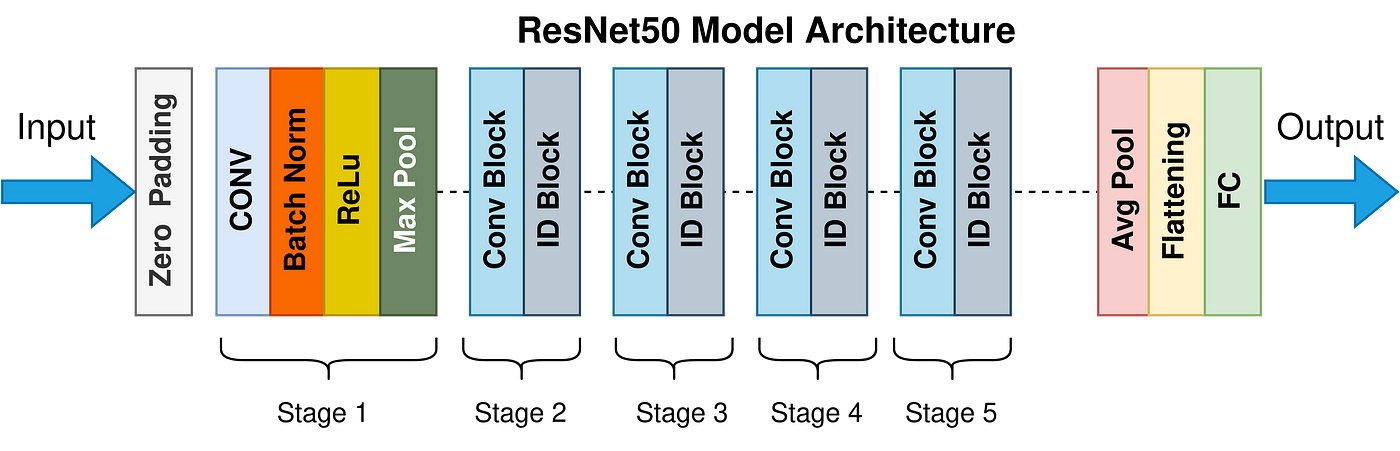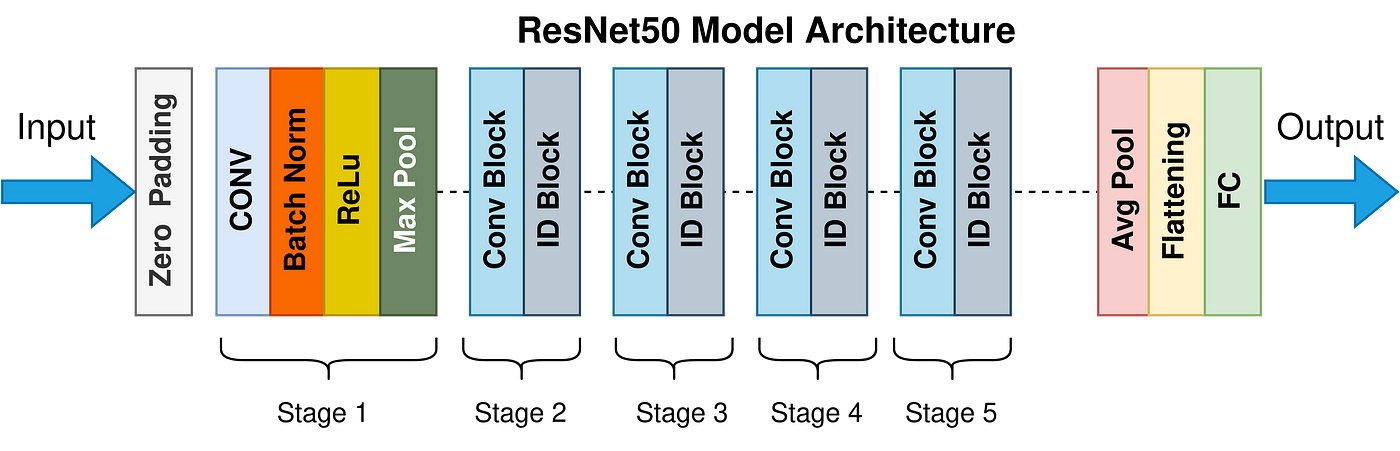

LINK: https://towardsdatascience.com/the-annotated-resnet-50-a6c536034758


The learner, we will use 

## Resnet50
## our metrics are accuracy, precision and recall
## we will use early stopping, if the accuracy doesn't increase then we will stop

In [50]:
learn = vision_learner(dls, resnet50, metrics=[accuracy,
               Precision(average='macro'),
               Recall(average='macro')], cbs=EarlyStoppingCallback(monitor='accuracy', min_delta=0.03, patience=2))

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.291402,0.834665,0.500000,0.597902,0.571307,00:21
1,1.052908,0.837870,0.720000,0.715545,0.728353,00:21
2,0.820348,0.854460,0.800000,0.789062,0.782683,00:20
3,0.676188,0.815227,0.790000,0.779121,0.769525,00:21
4,0.538635,0.835668,0.770000,0.758262,0.768676,00:22


No improvement since epoch 2: early stopping


#### Let's look at the metrics

In [53]:
d = [["Validation loss", "Accuracy", "Precision", "Recall"],learn.validate()]
df_acc = pd.DataFrame(np.array(d[1:]), columns=d[0])

<AxesSubplot:>

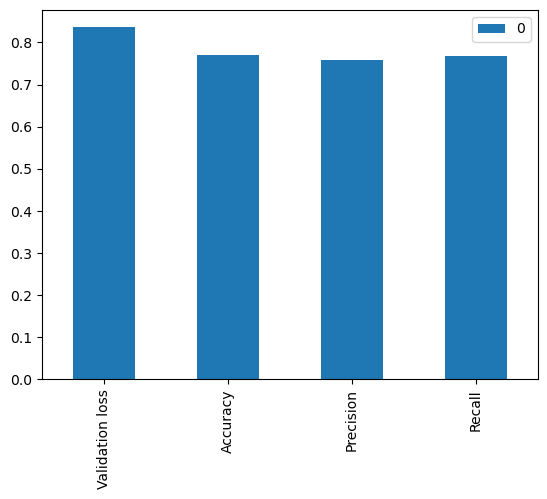

In [54]:
df_acc.T.plot(kind='bar')

# Eval

Now that we have our model, what should the submission look like. Let's see. 

In [55]:
sub = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")

In [56]:
sub.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


Okay, so let's run interference on our model. For that we modify the paths and run the predictions. 

In [89]:
testf = "/kaggle/input/histopathologic-cancer-detection/test/" + sub["id"] + ".tif"


testd = learn.dls.test_dl(testf)
pred = learn.get_preds(dl=testd, with_decoded=True)[2]


In [90]:

pred = np.array(pred)

In [91]:
sub.loc[:,"label"] = pred
sub.head(10)

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,1
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
5,725dabe6ecccc68b958a2c7dd75bcbf362c7cb03,0
6,aa0307865281d4484ddf8c637c348292968b93a7,0
7,f4e5dc9c949920f1b3362982e15e99bf6f3ef83b,0
8,95e08c9cedc28a9b4a86f4fc1e06c1972134be08,0
9,ee1f5345a8d4e28403b7e61b97b5f76c201ce9cb,1


In [92]:
sub.to_csv("submission123.csv", index=False)